In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from models import *
from graph_loaders import *
import networkx as nx
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
#import graphwave
#from graphwave.shapes import build_graph
#from graphwave.graphwave import *

np.random.seed(124)

In [2]:
current_palette = sns.color_palette("hls", 6)
sns.set_palette(current_palette)

## Picture of house graph

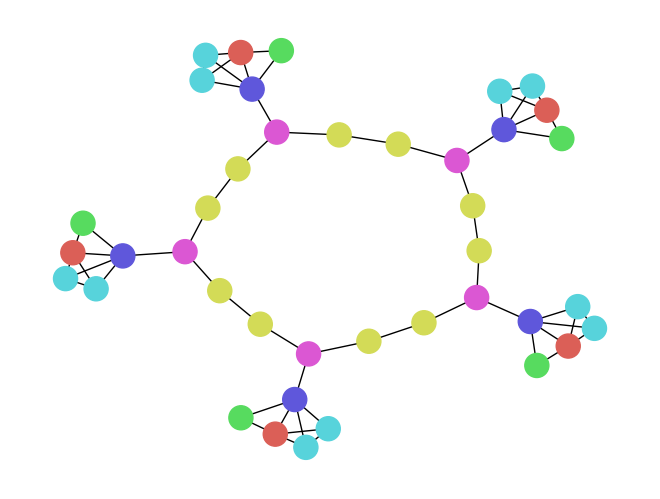

In [4]:
g, features = generate_house()
for n1, n2, attr in g.edges(data=True):
    attr['weight'] = 1.0
labels = set([g.nodess[x]['label'] for x in g.nodess])
colors = {label: idx for idx, label in enumerate(labels)}
pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos, node_color=[current_palette[colors[g.nodess[x]['label']]] for x in g.nodess()])
plt.show()

In [6]:
features

tensor([[3., 5., 2., 2., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [3., 5., 2., 2., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [3., 5., 2., 2., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [3., 5., 2., 2., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [3., 5., 2., 2., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [2., 3., 2., 0., 0., 0.],
        [3., 5., 4., 3., 0., 0.],
        [3., 5., 4., 3., 0., 0.],
        [4., 5., 3., 3., 2., 0.],
        [5., 4., 3., 3., 3., 2.],
        [2., 5., 4., 0., 0., 0.],
        [3., 5., 4., 3., 0., 0.],
        [3., 5., 4., 3., 0., 0.],
        [4., 5., 3., 3., 2., 0.],
        [5., 4., 3., 3., 3., 2.],
        [2., 5., 4., 0., 0., 0.],
        [3., 5., 4., 3., 0., 0.],
        [3., 5., 4., 3., 0., 0.],
        [4., 5., 3., 3., 2., 0.],
        [5., 4., 3., 3., 3., 2.],
        [2., 5

## Simple version of model

In [7]:
node_list = [x for x in g.nodess]

model1 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer1 = optim.Adam(
    model1.parameters(),
    lr=0.01,
)
model2 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer2 = optim.Adam(
    model2.parameters(),
    lr=0.01,
)

In [8]:
for _ in range(50):
    model1 = model1.train()
    model2 = model2.train()
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    emb_u = model1(node_list)
    emb_v = model2(node_list) # u can equal to v
    emb_neg = torch.cat(
        (
            model2([random.choice(node_list) for _ in range(len(node_list))]),
            model2(node_list, randomize_features=True),
        ),
        dim=1,
    ).view(2 * len(node_list), -1)
    pos_weight = emb_neg.numel() / emb_u.numel()
    loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
    print(float(loss.data.numpy()))
    loss.backward()
    optimizer1.step()
    optimizer2.step()

1.6182637214660645
1.5959463119506836
1.6485118865966797
1.7344110012054443
1.661238431930542
1.673041582107544
1.348221778869629
1.5705924034118652
1.4909776449203491
1.5823006629943848
1.6489217281341553
1.5557233095169067
1.748111367225647
1.6553535461425781
1.317347526550293
1.5495176315307617
1.5331573486328125
1.5769031047821045
1.689058542251587
1.5862772464752197
1.4120457172393799
1.3764493465423584
1.440446376800537
1.4665756225585938
1.4049842357635498
1.6001298427581787
1.3748853206634521
1.4208256006240845
1.478450059890747
1.412062644958496
1.45478093624115
1.5748798847198486
1.4463176727294922
1.3421157598495483
1.4926671981811523
1.3255176544189453
1.464716911315918
1.4360318183898926
1.4655747413635254
1.5424532890319824
1.3926372528076172
1.3053500652313232
1.460857629776001
1.3417723178863525
1.4121794700622559
1.4051557779312134
1.3745620250701904
1.3871145248413086
1.4327019453048706
1.3654437065124512


In [9]:
model1 = model1.eval()
emb = torch.cat(
    (
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
    ),
    dim=1,
).mean(dim=1)

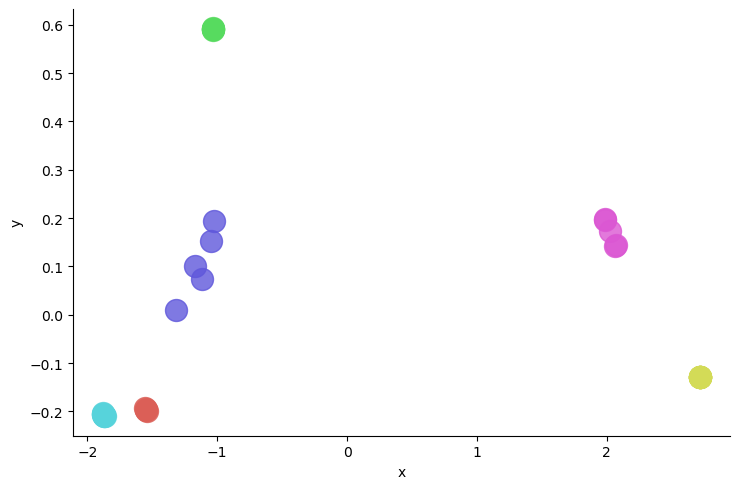

In [11]:
output = emb.data.numpy()
pca = PCA(n_components=2)
output = pd.DataFrame(pca.fit_transform(output))

output.columns = ['x', 'y']
output['color'] = [colors[g.nodess[idx]['label']] for idx in node_list]


sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 250},
)
plt.show()

In [12]:
shs = []

for _ in range(50):
    node_list = [x for x in g.nodes]

    model1 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer1 = optim.Adam(
        model1.parameters(),
        lr=0.01,
    )
    model2 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer2 = optim.Adam(
        model2.parameters(),
        lr=0.01,
    )
    for _ in range(100):
        model1 = model1.train()
        model2 = model2.train()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        emb_u = model1(node_list)
        emb_v = model2(node_list)
        emb_neg = torch.cat(
            (
                #model2([random.choice(node_list) for _ in range(len(node_list))]),
                #model2([random.choice(node_list) for _ in range(len(node_list))]),
                model2(node_list, randomize_features=True),
                model2(node_list, randomize_features=True),
            ),
            dim=1,
        ).view(2 * len(node_list), -1)
        pos_weight = emb_neg.numel() / emb_u.numel()
        loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
        loss.backward()
        optimizer1.step()
        optimizer2.step()

    model1 = model1.eval()
    emb = torch.cat(
        (
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
        ),
        dim=1,
    ).mean(dim=1)
    
    output = emb.data.numpy()
    pca = PCA(n_components=2)
    output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))

    output.columns = ['x', 'y']
    output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]
    shs.append(silhouette_score(output[['x', 'y']], output['color']))
    
print(np.mean(shs), np.std(shs))

0.90926903 0.024802634


## Between

In [13]:
node_list = [x for x in g.nodes]

model1 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer1 = optim.Adam(
    model1.parameters(),
    lr=0.01,
)
model2 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer2 = optim.Adam(
    model2.parameters(),
    lr=0.01,
)

In [13]:
for _ in range(50):
    model1 = model1.train()
    model2 = model2.train()
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    emb_u = model1(node_list)
    emb_v = model2([random.choice(list(g[x])) for x in node_list]) ## diff from simple, some random node v, neighbour shuffling
    emb_neg = torch.cat(
        (
            model2([random.choice(node_list) for _ in range(len(2 * node_list))]), # use neighbours of this random node v
            # model1(node_list, randomize_features=True),
        ),
        dim=1,
    ).view(2 * len(node_list), -1)
    pos_weight = emb_neg.numel() / emb_u.numel()
    loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
    print(float(loss.data.numpy()))
    loss.backward()
    optimizer1.step()
    optimizer2.step()

1.7584469318389893
1.5807669162750244
1.5406413078308105
1.367748737335205
1.7475368976593018
1.5848743915557861
1.4279824495315552
1.512531042098999
1.1644032001495361
1.4697439670562744
1.5985708236694336
1.5990278720855713
1.5221099853515625
1.4178886413574219
1.5927445888519287
1.3327778577804565
1.5233354568481445
1.4713175296783447
1.5173425674438477
1.5218865871429443
1.6721018552780151
1.5543054342269897
1.417419195175171
1.4117814302444458
1.4264413118362427
1.3916418552398682
1.5205717086791992
1.3989450931549072
1.527522325515747
1.4527901411056519
1.3827145099639893
1.372565746307373
1.3567805290222168
1.5114469528198242
1.3541271686553955
1.455885648727417
1.4264395236968994
1.4630534648895264
1.3366141319274902
1.3999484777450562
1.5443625450134277
1.3487625122070312
1.433424711227417
1.3162715435028076
1.357426404953003
1.526625394821167
1.4928185939788818
1.4180785417556763
1.3047475814819336
1.310383677482605


In [14]:
node_list = [x for x in g.nodes]

model1 = model1.eval()
emb = torch.cat(
    (
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
    ),
    dim=1,
).mean(dim=1)

In [15]:
emb.size()

torch.Size([40, 10])

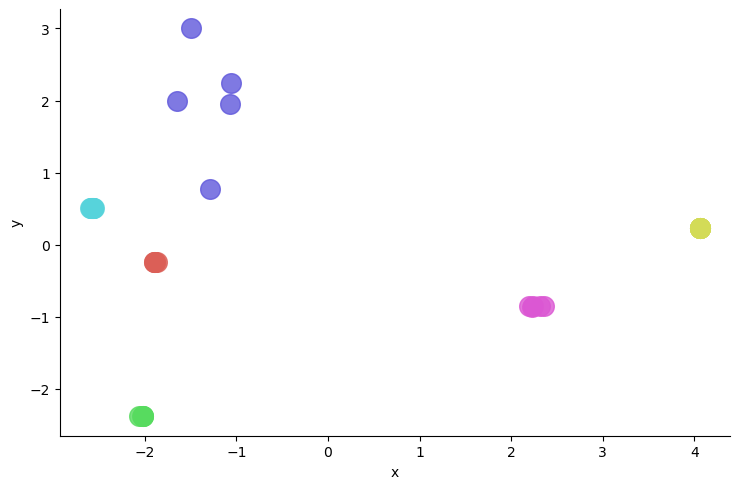

In [16]:
output = emb.data.numpy()
pca = PCA(n_components=2)
output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))
output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]

sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()

In [17]:
shs = []

for _ in range(50):
    node_list = [x for x in g.nodes]

    model1 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer1 = optim.Adam(
        model1.parameters(),
        lr=0.01,
    )
    model2 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer2 = optim.Adam(
        model2.parameters(),
        lr=0.01,
    )
    for _ in range(100):
        model1 = model1.train()
        model2 = model2.train()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        emb_u = model1(node_list)
        emb_v = model2([random.choice(list(g[x])) for x in node_list])
        emb_neg = torch.cat(
            (
                model2([random.choice(node_list) for _ in range(len(2 * node_list))]),
                # model1(node_list, randomize_features=True),
            ),
            dim=1,
        ).view(2 * len(node_list), -1)
        pos_weight = emb_neg.numel() / emb_u.numel()
        loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
    model1 = model1.eval()
    emb = torch.cat(
        (
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
        ),
        dim=1,
    ).mean(dim=1)
    
    output = emb.data.numpy()
    pca = PCA(n_components=2)
    output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))

    output.columns = ['x', 'y']
    output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]
    shs.append(silhouette_score(output[['x', 'y']], output['color']))
    
print(np.mean(shs), np.std(shs))

0.90328956 0.033610452


## Graphwave

In [ ]:
chi, heat_print, taus = graphwave_alg(g, np.linspace(0,100,25), taus='auto', verbose=True)

In [ ]:
pca = PCA(n_components=2)
graphwave_emb = pca.fit_transform(StandardScaler().fit_transform(chi))

In [ ]:
node_list = [x for x in g.nodes]
output = pd.DataFrame(graphwave_emb)
output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]

sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()

## Node2vec / DeepWalk

In [ ]:
from node2vec.src import node2vec
from gensim.models import Word2Vec

In [ ]:
for n1, n2, data in g.edges(data=True):
    data['weight'] = 1.0

G = node2vec.Graph(g, is_directed=False, p=1.0, q=1.0)
G.preprocess_transition_probs()
walks = G.simulate_walks(10, 80)
walks = [[str(w) for w in walk] for walk in walks]
model = Word2Vec(walks, size=8, window=10, min_count=0, sg=1, workers=1, iter=10)
wvs = model.wv

In [ ]:
output = wvs[[str(node) for node in node_list]]
pca = PCA(n_components=2)
output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))
output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]

sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()

## Picture of barbell graph

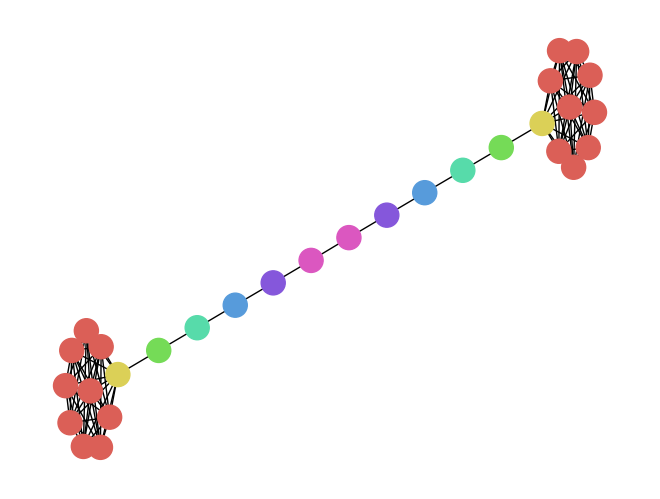

In [18]:
current_palette = sns.color_palette("hls", 7)
sns.set_palette(current_palette)
g, features = generate_barbell()
for n1, n2, attr in g.edges(data=True):
    attr['weight'] = 1.0
labels = set([g.nodes[x]['label'] for x in g.nodes])
colors = {label: idx for idx, label in enumerate(labels)}
pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos, node_color=[current_palette[colors[g.nodes[x]['label']]] for x in g.nodes()])
plt.show()

## Simple version of model

In [19]:
node_list = [x for x in g.nodes]

model1 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer1 = optim.Adam(
    model1.parameters(),
    lr=0.01,
)
model2 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer2 = optim.Adam(
    model2.parameters(),
    lr=0.01,
)
for _ in range(50):
    model1 = model1.train()
    model2 = model2.train()
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    emb_u = model1(node_list)
    emb_v = model2(node_list)
    emb_neg = torch.cat(
        (
            #model2([random.choice(node_list) for _ in range(len(node_list))]),
            model2(node_list, randomize_features=True),
            model2(node_list, randomize_features=True),
        ),
        dim=1,
    ).view(2 * len(node_list), -1)
    pos_weight = emb_neg.numel() / emb_u.numel()
    loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
    print(float(loss.data.numpy()))
    loss.backward()
    optimizer1.step()
    optimizer2.step()

1.5490655899047852
1.7661445140838623
1.7080506086349487
1.4556301832199097
1.7988028526306152
1.6917814016342163
1.519806146621704
1.7245558500289917
1.4871299266815186
1.3379969596862793
1.3712663650512695
1.656017541885376
1.3780605792999268
1.5987311601638794
1.387430191040039
1.4005415439605713
1.4822688102722168
1.2545009851455688
1.547407865524292
1.3938602209091187
1.5129625797271729
1.4345061779022217
1.4929993152618408
1.3534514904022217
1.493630051612854
1.5317893028259277
1.325742483139038
1.5024573802947998
1.3887298107147217
1.2511518001556396
1.3798009157180786
1.628401756286621
1.5525450706481934
1.3590848445892334
1.3568346500396729
1.4213049411773682
1.5192632675170898
1.5858365297317505
1.3744359016418457
1.3607672452926636
1.4258344173431396
1.492821455001831
1.2396843433380127
1.4237844944000244
1.362339973449707
1.411404013633728
1.4452894926071167
1.4388797283172607
1.461923360824585
1.424877405166626


In [20]:
model1 = model1.eval()
emb = torch.cat(
    (
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
    ),
    dim=1,
).mean(dim=1)

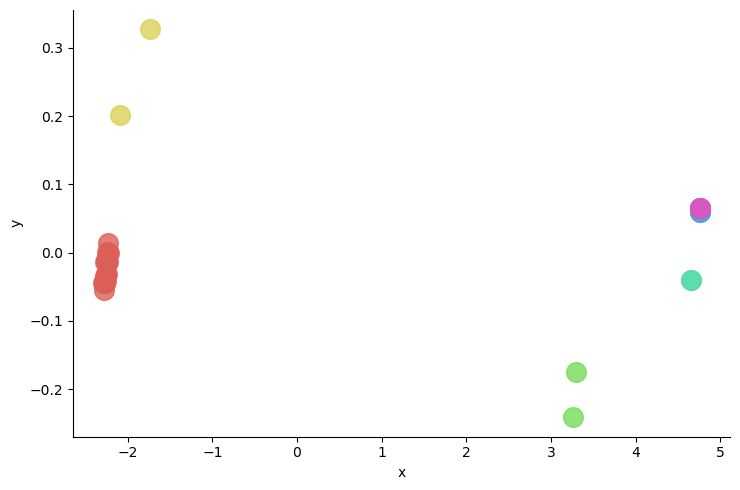

In [21]:
output = emb.data.numpy()
pca = PCA(n_components=2)
output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))

output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]

sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()

In [22]:
shs = []

for _ in range(50):
    node_list = [x for x in g.nodes]

    model1 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer1 = optim.Adam(
        model1.parameters(),
        lr=0.01,
    )
    model2 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer2 = optim.Adam(
        model2.parameters(),
        lr=0.01,
    )
    for _ in range(100):
        model1 = model1.train()
        model2 = model2.train()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        emb_u = model1(node_list)
        emb_v = model2(node_list)
        emb_neg = torch.cat(
            (
                model2(node_list, randomize_features=True),
                model2(node_list, randomize_features=True),
            ),
            dim=1,
        ).view(2 * len(node_list), -1)
        pos_weight = emb_neg.numel() / emb_u.numel()
        loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
        loss.backward()
        optimizer1.step()
        optimizer2.step()

    model1 = model1.eval()
    emb = torch.cat(
        (
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
        ),
        dim=1,
    ).mean(dim=1)
    
    output = emb.data.numpy()
    pca = PCA(n_components=2)
    output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))

    output.columns = ['x', 'y']
    output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]
    output[['x', 'y']] = output[['x', 'y']] + 0.01 * np.random.normal(0, 1, size=output[['x', 'y']].shape)
    shs.append(silhouette_score(output[['x', 'y']], output['color']))
    
print(np.mean(shs), np.std(shs))

0.649748770595674 0.08941751510562272


## Between

In [23]:
node_list = [x for x in g.nodes]

model1 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer1 = optim.Adam(
    model1.parameters(),
    lr=0.01,
)
model2 = MeanModel(
    emb_dim=2,
    n_nbr_samples1=4,
    n_nbr_samples2=2,
    g=g,
    features=features,
)
optimizer2 = optim.Adam(
    model2.parameters(),
    lr=0.01,
)
for _ in range(50):
    model1 = model1.train()
    model2 = model2.train()
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    emb_u = model1(node_list)
    emb_v = model2([random.choice(list(g[x])) for x in node_list])
    emb_neg = torch.cat(
        (
            model2([random.choice(node_list) for _ in range(len(2 * node_list))]),
            # model1(node_list, randomize_features=True),
        ),
        dim=1,
    ).view(2 * len(node_list), -1)
    pos_weight = emb_neg.numel() / emb_u.numel()
    loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
    print(float(loss.data.numpy()))
    loss.backward()
    optimizer1.step()
    optimizer2.step()

1.3729517459869385
1.7154247760772705
2.073326587677002
1.6671115159988403
1.6962891817092896
1.6378402709960938
1.4406770467758179
1.5026254653930664
1.819633960723877
1.5073871612548828
1.6856942176818848
1.518467903137207
1.5304471254348755
1.6283411979675293
1.5523309707641602
1.6302924156188965
1.4520659446716309
1.5181190967559814
1.838429570198059
1.8175032138824463
1.3530690670013428
1.4933092594146729
1.6389044523239136
1.5395476818084717
1.607450008392334
1.3182547092437744
1.5380618572235107
1.5648492574691772
1.4532849788665771
1.3146127462387085
1.7014925479888916
1.5406343936920166
1.4756851196289062
1.4501532316207886
1.495220422744751
1.3821325302124023
1.4742944240570068
1.4668285846710205
1.5451987981796265
1.4205142259597778
1.3487827777862549
1.271298885345459
1.3260483741760254
1.3972899913787842
1.4423816204071045
1.3250812292099
1.4118096828460693
1.3987770080566406
1.3987207412719727
1.346297264099121


In [24]:
model1 = model1.eval()
emb = torch.cat(
    (
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
        model1(node_list).unsqueeze(1),
    ),
    dim=1,
).mean(dim=1)

In [25]:
emb.size()

torch.Size([30, 10])

0.74289066


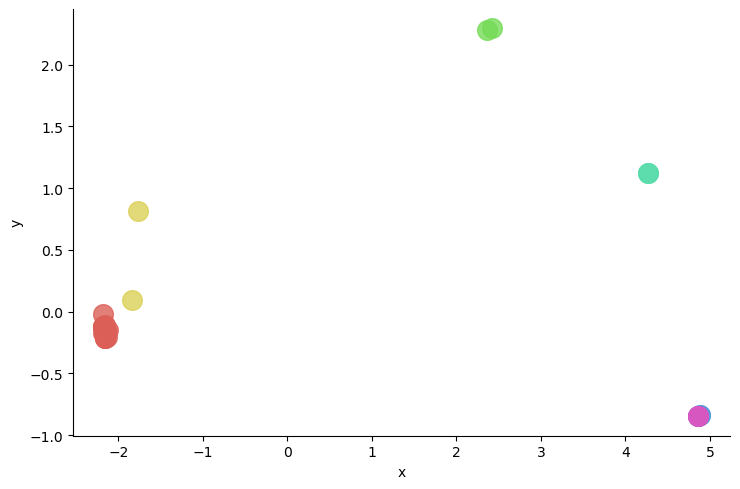

In [26]:
output = emb.data.numpy()
pca = PCA(n_components=2)
output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))
output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]

print(silhouette_score(output[['x', 'y']], output['color']))


sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()

In [27]:
shs = []

for _ in range(50):
    node_list = [x for x in g.nodes]

    model1 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer1 = optim.Adam(
        model1.parameters(),
        lr=0.01,
    )
    model2 = MeanModel(
        emb_dim=2,
        n_nbr_samples1=4,
        n_nbr_samples2=2,
        g=g,
        features=features,
    )
    optimizer2 = optim.Adam(
        model2.parameters(),
        lr=0.01,
    )
    for _ in range(100):
        model1 = model1.train()
        model2 = model2.train()
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        emb_u = model1(node_list)
        emb_v = model2([random.choice(list(g[x])) for x in node_list])
        emb_neg = torch.cat(
            (
                model2([random.choice(node_list) for _ in range(len(2 * node_list))]),
                # model1(node_list, randomize_features=True),
            ),
            dim=1,
        ).view(2 * len(node_list), -1)
        pos_weight = emb_neg.numel() / emb_u.numel()
        loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
    model1 = model1.eval()
    emb = torch.cat(
        (
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
            model1(node_list).unsqueeze(1),
        ),
        dim=1,
    ).mean(dim=1)
    
    output = emb.data.numpy()
    pca = PCA(n_components=2)
    output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))

    output.columns = ['x', 'y']
    output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]
    output[['x', 'y']] = output[['x', 'y']] + 0.01 * np.random.normal(0, 1, size=output[['x', 'y']].shape)
    shs.append(silhouette_score(output[['x', 'y']], output['color']))
    
print(np.mean(shs), np.std(shs))

0.6585123577832894 0.09508740311401712


## Graphwave

In [ ]:
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import graphwave.graphwave as graphwave
from graphwave.graphwave.shapes import build_graph
from graphwave.graphwave.graphwave import *


np.random.seed(123)

In [ ]:
chi, heat_print, taus = graphwave_alg(g, np.linspace(0,100,25), taus='auto', verbose=True)

In [ ]:
pca = PCA(n_components=2)
graphwave_emb = pca.fit_transform(StandardScaler().fit_transform(chi))

In [ ]:
node_list = [x for x in g.nodes]
output = pd.DataFrame(graphwave_emb)
output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[idx]['label']] for idx in node_list]

sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()

## Node2vec / DeepWalk

In [ ]:
from node2vec.src import node2vec
from gensim.models import Word2Vec

In [ ]:
for n1, n2, data in g.edges(data=True):
    data['weight'] = 1.0

G = node2vec.Graph(g, is_directed=False, p=1.0, q=1.0)
G.preprocess_transition_probs()
walks = G.simulate_walks(10, 80)
walks = [[str(w) for w in walk] for walk in walks]
model = Word2Vec(walks, size=8, window=10, min_count=0, sg=1, workers=1, iter=10)
wvs = model.wv


In [ ]:
output = wvs[[str(node) for node in node_list]]
pca = PCA(n_components=2)
output = pd.DataFrame(pca.fit_transform(StandardScaler().fit_transform(output)))
output.columns = ['x', 'y']
output['color'] = [colors[g.nodes[x]['label']] for x in node_list]

sns.lmplot(
    x='x',
    y='y',
    data=output,
    fit_reg=False,
    hue='color',
    legend=False,
    height=5,
    aspect=1.5,
    scatter_kws={"s": 200},
)
plt.show()